In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, fbeta_score

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# read in data
df = pd.read_csv('./input/creditcard.csv')

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.describe().T.to_csv('./Data_Schema/df_describe.csv')

In [5]:
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


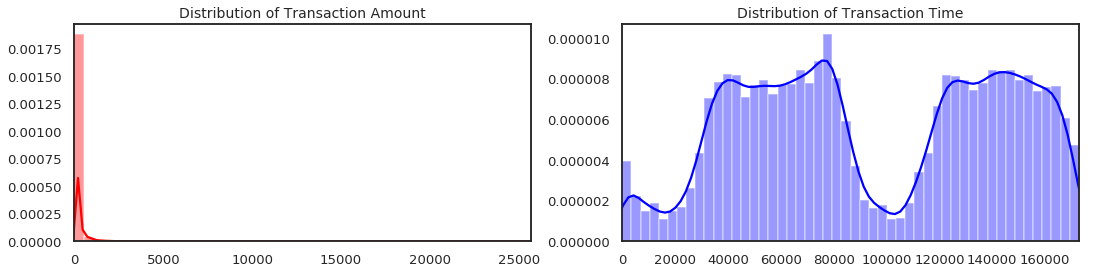

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [7]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

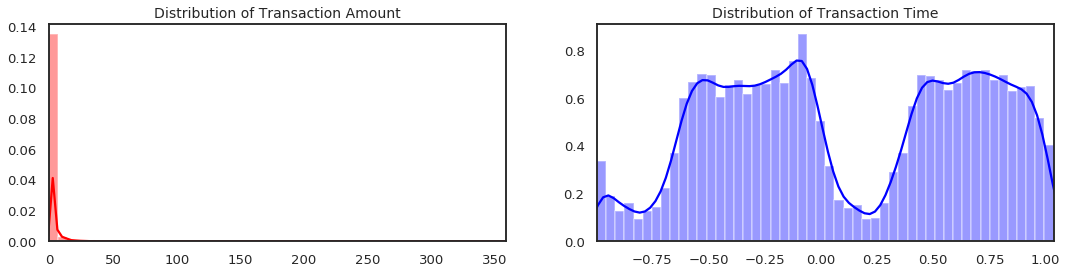

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['scaled_amount'].values
time_val = df['scaled_time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

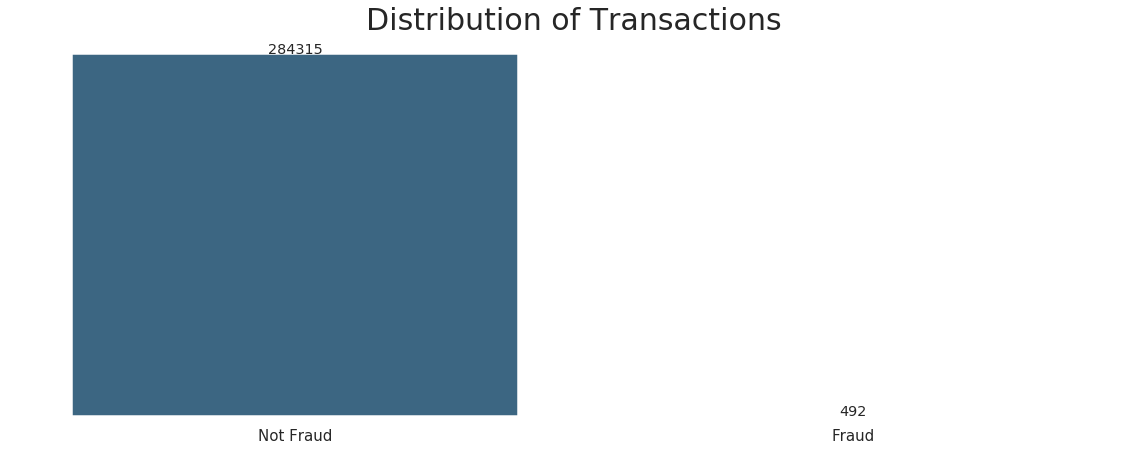

In [9]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()


In [10]:
# print percentage of questions where target == 1
(len(df.loc[df.Class==1])) / (len(df.loc[df.Class == 0])) * 100

0.17304750013189596

In [11]:
# Prepare data for modeling
# Separate input features and target
X = df.drop('Class', axis=1)
y = df.Class

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# concatenate our training data back together
Train = pd.concat([X_train, y_train], axis=1)
Train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time,Class
264873,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,-0.343885,...,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,-0.269126,0.903934,0
163821,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,0.443750,...,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,0.229721,0.370599,0
72083,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,-0.113006,...,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,-0.293440,-0.354034,0
196949,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,0.334537,...,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,0.222036,0.553096,0
126213,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,0.754427,...,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,3.004262,-0.079101,0


In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


# 1. 성과지표(Accuracy >> Recall/Precision/f1)

In [13]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.9981461194910255


# LogisticRegression

In [14]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# checking accuracy
print('Test score: ', accuracy_score(y_test, lr_pred))

Test score:  0.9992275497879273


In [15]:
lr_predictions = pd.DataFrame(lr_pred)
lr_predictions[0].value_counts()

0    71111
1       91
Name: 0, dtype: int64

In [16]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, lr_pred))

,0,1
0,71063,7
1,48,84


In [19]:
print('recall   :{3} = {0}/({0}+{1})\nprecision:{4} = {0}/({0}+{2})\nf1       :{5} = 2/(1/{3}+1/{4})'.
      format(78, 
             54, 
             10, 
             78 / (54 + 78), 
             78/ (78 + 10),
             2/(1/(78 / (54 + 78))+1/(78/ (78 + 10)))))

recall   :0.5909090909090909 = 78/(78+54)
precision:0.8863636363636364 = 78/(78+10)
f1       :0.7090909090909091 = 2/(1/0.5909090909090909+1/0.8863636363636364)


In [20]:
# score value
print('        Accuracy /     Recall /  Precision /         F1')
print('LR  : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))

        Accuracy /     Recall /  Precision /         F1
LR  :    0.99923 /    0.63636 /    0.92308 /    0.75336


## 2. 알고리즘 변경(LinearRegression >> RandomForestClassifier)
###    RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.9995786635206876

In [22]:
rfc_predictions = pd.DataFrame(rfc_pred)
rfc_predictions[0].value_counts()

0    71090
1      112
Name: 0, dtype: int64

In [23]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, rfc_pred))

,0,1
0,71065,5
1,25,107


In [24]:
print('recall   :{3} = {0}/({0}+{1})\nprecision:{4} = {0}/({0}+{2})\nf1       :{5} = 2/(1/{3}+1/{4})'.
      format(104, 
             28, 
             3, 
             104 / (28 + 104), 
             104/ (104 + 3),
             2/(1/(104 / (28 + 104))+1/(104/ (104 + 3)))))

recall   :0.7878787878787878 = 104/(104+28)
precision:0.9719626168224299 = 104/(104+3)
f1       :0.8702928870292886 = 2/(1/0.7878787878787878+1/0.9719626168224299)


In [25]:
print('        Accuracy /     Recall /  Precision /         F1')
print('LR  : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))

        Accuracy /     Recall /  Precision /         F1
LR  :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC :    0.99958 /    0.81061 /    0.95536 /    0.87705


# 3. Resampling Techniques
      - Oversampling Minority Class

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don't have a ton of data to work with. A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

Important Note
Always split into test and train sets BEFORE trying any resampling techniques! Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets! This can allow our model to simply memorize specific data points and cause overfitting.

오버 샘플링은 소수 클래스의 사본을 더 추가하는 것으로 정의 할 수 있습니다. 작업 할 데이터가 많지 않은 경우 오버 샘플링을 선택하는 것이 좋습니다. 언더 샘플링시 고려해야 할 단점은 테스트 세트에 과적 합 및 일반화가 잘못 될 수 있다는 것입니다.

Scikit-Learn의 리샘플링 모듈을 사용하여 소수 클래스의 샘플을 무작위로 복제합니다.

중요 사항
리샘플링 기술을 시도하기 전에 항상 테스트 및 트레인 세트로 분할하십시오! 데이터를 분할하기 전에 오버 샘플링하면 테스트와 트레인 세트 모두에 똑같은 관측 값이 표시 될 수 있습니다! 이를 통해 모델이 특정 데이터 포인트를 암기하고 과적 합을 유발할 수 있습니다.

In [26]:
# separate minority and majority classes
not_fraud = Train[Train.Class==0]
fraud = Train[Train.Class==1]

In [27]:
Train.Class.value_counts()

0    213245
1       360
Name: Class, dtype: int64

In [28]:
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])
# check new class counts
upsampled.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [31]:
fraud_upsampled.sort_values(by=['scaled_time'])

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time,Class
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.307413,-0.990214,1
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.307413,-0.990214,1
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.307413,-0.990214,1
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.307413,-0.990214,1
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.307413,-0.990214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,0.780968,0.994596,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,0.780968,0.994596,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,0.780968,0.994596,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,0.780968,0.994596,1


In [32]:
# trying logistic regression again with the balanced dataset
y_train_up = upsampled.Class
X_train_up = upsampled.drop('Class', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train_up, y_train_up)

upsampled_pred = upsampled.predict(X_test)

In [33]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_pred))

,0,1
0,69546,1524
1,15,117


In [34]:
print('             Accuracy /     Recall /  Precision /         F1')
print('LR       : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))
print('Resample : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred)))

             Accuracy /     Recall /  Precision /         F1
LR       :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC      :    0.99958 /    0.81061 /    0.95536 /    0.87705
Resample :    0.97839 /    0.88636 /    0.07130 /    0.13198


### Upsampling후에 RandomForest

In [35]:
# separate minority and majority classes
not_fraud = Train[Train.Class==0]
fraud = Train[Train.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])
# check new class counts
upsampled.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [36]:
# trying logistic regression again with the balanced dataset
y_train_up = upsampled.Class
X_train_up = upsampled.drop('Class', axis=1)
upsampled_rfc = RandomForestClassifier(n_estimators=10).fit(X_train_up, y_train_up)
upsampled_rfc_pred = upsampled_rfc.predict(X_test)

In [37]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_rfc_pred))

,0,1
0,71067,3
1,24,108


In [38]:
print('             Accuracy /     Recall /  Precision /         F1')
print('LR       : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))
print('Resample : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred)))
print('Up RFC   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_rfc_pred), recall_score(y_test, upsampled_rfc_pred), precision_score(y_test, upsampled_rfc_pred), f1_score(y_test, upsampled_rfc_pred)))


             Accuracy /     Recall /  Precision /         F1
LR       :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC      :    0.99958 /    0.81061 /    0.95536 /    0.87705
Resample :    0.97839 /    0.88636 /    0.07130 /    0.13198
Up RFC   :    0.99962 /    0.81818 /    0.97297 /    0.88889


# 4. 언더 샘플링 과반수 클래스
언더 샘플링은 대다수 클래스의 일부 관측치를 제거하는 것으로 정의 할 수 있습니다. 언더 샘플링은 수백만 행의 데이터를 생각할 때 좋은 선택이 될 수 있습니다. 그러나 언더 샘플링의 단점은 가치있는 정보를 제거한다는 것입니다.

Scikit-Learn의 리샘플링 모듈을 다시 사용하여 대다수 클래스에서 샘플을 무작위로 제거합니다.

In [39]:
# separate minority and majority classes
not_fraud = Train[Train.Class==0]
fraud = Train[Train.Class==1]

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [40]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.Class
X_train_down = downsampled.drop('Class', axis=1)

downsampled = LogisticRegression(solver='liblinear').fit(X_train_down, y_train_down)

downsampled_pred = downsampled.predict(X_test)

In [41]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, downsampled_pred))

,0,1
0,68593,2477
1,15,117


In [42]:
print('               Accuracy /     Recall /  Precision /         F1')
print('LR         : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC        : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))
print('Up LR      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred)))
print('Up RFC     : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_rfc_pred), recall_score(y_test, upsampled_rfc_pred), precision_score(y_test, upsampled_rfc_pred), f1_score(y_test, upsampled_rfc_pred)))
print('Down LR    : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_pred), recall_score(y_test, downsampled_pred), precision_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred)))

               Accuracy /     Recall /  Precision /         F1
LR         :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC        :    0.99958 /    0.81061 /    0.95536 /    0.87705
Up LR      :    0.97839 /    0.88636 /    0.07130 /    0.13198
Up RFC     :    0.99962 /    0.81818 /    0.97297 /    0.88889
Down LR    :    0.96500 /    0.88636 /    0.04510 /    0.08584


### DownSampling후에 RandomForest

In [43]:
# separate minority and majority classes
not_fraud = Train[Train.Class==0]
fraud = Train[Train.Class==1]

# downsample minority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [44]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.Class
X_train_down = downsampled.drop('Class', axis=1)

downsampled_rfc = RandomForestClassifier(n_estimators=10).fit(X_train_down, y_train_down)
downsampled_rfc_pred = downsampled_rfc.predict(X_test)

In [45]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, downsampled_rfc_pred))

,0,1
0,69472,1598
1,16,116


In [46]:
print('               Accuracy /     Recall /  Precision /         F1')
print('LR         : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC        : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))
print('Up LR      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred)))
print('Up RFC     : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_rfc_pred), recall_score(y_test, upsampled_rfc_pred), precision_score(y_test, upsampled_rfc_pred), f1_score(y_test, upsampled_rfc_pred)))
print('Down LR    : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_pred), recall_score(y_test, downsampled_pred), precision_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred)))
print('Down RFC   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_rfc_pred), recall_score(y_test, downsampled_rfc_pred), precision_score(y_test, downsampled_rfc_pred), f1_score(y_test, downsampled_rfc_pred)))

               Accuracy /     Recall /  Precision /         F1
LR         :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC        :    0.99958 /    0.81061 /    0.95536 /    0.87705
Up LR      :    0.97839 /    0.88636 /    0.07130 /    0.13198
Up RFC     :    0.99962 /    0.81818 /    0.97297 /    0.88889
Down LR    :    0.96500 /    0.88636 /    0.04510 /    0.08584
Down RFC   :    0.97733 /    0.87879 /    0.06768 /    0.12568


# 5. Generate Synthetic Samples
SMOTE 또는 Synthetic Minority Oversampling Technique은 소수 클래스의 sythetic 관찰을 생성하는 인기있는 알고리즘입니다.

In [47]:
!sudo pip install imblearn

In [51]:
sm = SMOTE(random_state=27, ratio=1.0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_SMOTE = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame({'Class':y_train_smote})], axis=1)
X_SMOTE.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [52]:
smote = LogisticRegression(solver='liblinear').fit(X_train_smote, y_train_smote)
smote_pred = smote.predict(X_test)

# Checking accuracy
accuracy_score(y_test, smote_pred)

0.9774725429060982

In [53]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, smote_pred))

,0,1
0,69481,1589
1,15,117


In [54]:
print('               Accuracy /     Recall /  Precision /         F1')
print('LR         : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC        : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))
print('Up LR      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred)))
print('Up RFC     : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_rfc_pred), recall_score(y_test, upsampled_rfc_pred), precision_score(y_test, upsampled_rfc_pred), f1_score(y_test, upsampled_rfc_pred)))
print('Down LR    : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_pred), recall_score(y_test, downsampled_pred), precision_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred)))
print('Down RFC   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_rfc_pred), recall_score(y_test, downsampled_rfc_pred), precision_score(y_test, downsampled_rfc_pred), f1_score(y_test, downsampled_rfc_pred)))
print('smote      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, smote_pred), recall_score(y_test, smote_pred), precision_score(y_test, smote_pred), f1_score(y_test, smote_pred)))

               Accuracy /     Recall /  Precision /         F1
LR         :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC        :    0.99958 /    0.81061 /    0.95536 /    0.87705
Up LR      :    0.97839 /    0.88636 /    0.07130 /    0.13198
Up RFC     :    0.99962 /    0.81818 /    0.97297 /    0.88889
Down LR    :    0.96500 /    0.88636 /    0.04510 /    0.08584
Down RFC   :    0.97733 /    0.87879 /    0.06768 /    0.12568
smote      :    0.97747 /    0.88636 /    0.06858 /    0.12731


### Generate Synthetic Sampling후에 RandomForest

In [55]:
sm = SMOTE(random_state=27, ratio=1.0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_SMOTE = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame({'Class':y_train_smote})], axis=1)
X_SMOTE.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [56]:
smote_rfc = RandomForestClassifier(n_estimators=10).fit(X_train_smote, y_train_smote)
smote_rfc_pred = smote_rfc.predict(X_test)
# Checking accuracy
accuracy_score(y_test, smote_rfc_pred)

0.999522485323446

In [57]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, smote_rfc_pred))

,0,1
0,71058,12
1,22,110


In [58]:
print('        Accuracy /     Recall /  Precision /         F1')
print('LR         : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred)))
print('RFC        : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred)))
print('Up LR      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred)))
print('Up RFC     : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_rfc_pred), recall_score(y_test, upsampled_rfc_pred), precision_score(y_test, upsampled_rfc_pred), f1_score(y_test, upsampled_rfc_pred)))
print('Down LR    : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_pred), recall_score(y_test, downsampled_pred), precision_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred)))
print('Down RFC   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_rfc_pred), recall_score(y_test, downsampled_rfc_pred), precision_score(y_test, downsampled_rfc_pred), f1_score(y_test, downsampled_rfc_pred)))
print('smote LR   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, smote_pred), recall_score(y_test, smote_pred), precision_score(y_test, smote_pred), f1_score(y_test, smote_pred)))
print('smote RFC  : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, smote_rfc_pred), recall_score(y_test, smote_rfc_pred), precision_score(y_test, smote_rfc_pred), f1_score(y_test, smote_rfc_pred)))


        Accuracy /     Recall /  Precision /         F1
LR         :    0.99923 /    0.63636 /    0.92308 /    0.75336
RFC        :    0.99958 /    0.81061 /    0.95536 /    0.87705
Up LR      :    0.97839 /    0.88636 /    0.07130 /    0.13198
Up RFC     :    0.99962 /    0.81818 /    0.97297 /    0.88889
Down LR    :    0.96500 /    0.88636 /    0.04510 /    0.08584
Down RFC   :    0.97733 /    0.87879 /    0.06768 /    0.12568
smote LR   :    0.97747 /    0.88636 /    0.06858 /    0.12731
smote RFC  :    0.99952 /    0.83333 /    0.90164 /    0.86614


In [60]:
from IPython import display
print('*'*100,'\nLogisticRegression')
display.display(pd.DataFrame(confusion_matrix(y_test, lr_pred)))
print('*'*100,'\nRandomForestClassifier')
#print('*'*100,RandomForestClassifier')
display.display(pd.DataFrame(confusion_matrix(y_test, rfc_pred)))
print('*'*100,'\nUpsampling LogisticRegression')
display.display(pd.DataFrame(confusion_matrix(y_test, upsampled_pred)))
print('*'*100,'\nUpsampling RandomForestClassifier')
display.display(pd.DataFrame(confusion_matrix(y_test, upsampled_rfc_pred)))
print('*'*100,'\nDownsampling LogisticRegression')
display.display(pd.DataFrame(confusion_matrix(y_test, downsampled_pred)))
print('*'*100,'\nDownsampling RandomForestClassifier')
display.display(pd.DataFrame(confusion_matrix(y_test, downsampled_rfc_pred)))
print('*'*100,'\nSynthetic SamplingLogisticRegression')
display.display(pd.DataFrame(confusion_matrix(y_test, smote_pred)))
print('*'*100,'\nSynthetic SamplingRandomForestClassifier')
display.display(pd.DataFrame(confusion_matrix(y_test, smote_rfc_pred)))

**************************************************************************************************** 
LogisticRegression


,0,1
0,71063,7
1,48,84


**************************************************************************************************** 
RandomForestClassifier


,0,1
0,71065,5
1,25,107


**************************************************************************************************** 
Upsampling LogisticRegression


,0,1
0,69546,1524
1,15,117


**************************************************************************************************** 
Upsampling RandomForestClassifier


,0,1
0,71067,3
1,24,108


**************************************************************************************************** 
Downsampling LogisticRegression


,0,1
0,68593,2477
1,15,117


**************************************************************************************************** 
Downsampling RandomForestClassifier


,0,1
0,69472,1598
1,16,116


**************************************************************************************************** 
Synthetic SamplingLogisticRegression


,0,1
0,69481,1589
1,15,117


**************************************************************************************************** 
Synthetic SamplingRandomForestClassifier


,0,1
0,71058,12
1,22,110


# Conclusion
We covered 5 different methods for dealing with imbalanced datasets:

1. Change the performance metric
2. Oversampling minority class
3. Undersampling majority class
4. Change the algorithm
5. Generate synthetic samples

#### These are just some of the many possible methods to try when dealing with imbalanced datasets, and not an exhaustive list. Some others methods to consider are collecting more data or choosing different resampling ratios - you don't have to have exactly a 1:1 ratio! You should always try several approaches and then decide which is best for your problem.
#### 이들은 불균형 데이터 세트를 다룰 때 시도 할 수있는 많은 방법 중 일부일 뿐이며 전체 목록은 아닙니다. 고려해야 할 다른 방법은 더 많은 데이터를 수집하거나 다른 리샘플링 비율을 선택하는 것입니다. 정확히 1 : 1 비율 일 필요는 없습니다! 항상 몇 가지 접근 방식을 시도한 다음 문제에 가장 적합한 방법을 결정해야합니다.

In [61]:
pd.DataFrame(confusion_matrix(y_test, lr_pred))

,0,1
0,71063,7
1,48,84


In [72]:
tp = pd.DataFrame(confusion_matrix(y_test, lr_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, lr_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, lr_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, lr_pred))[1][1]
lr_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, lr_mcc

(71063, 7, 48, 84, 0.7660888915942948)

In [70]:
tp = pd.DataFrame(confusion_matrix(y_test, rfc_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, rfc_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, rfc_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, rfc_pred))[1][1]
rfc_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, rfc_mcc

(71065, 5, 25, 107, 0.8798102290019919)

In [73]:
tp = pd.DataFrame(confusion_matrix(y_test, upsampled_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, upsampled_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, upsampled_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, upsampled_pred))[1][1]
upsampled_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, upsampled_mcc

(69546, 1524, 15, 117, 0.24795270965819663)

In [74]:
tp = pd.DataFrame(confusion_matrix(y_test, upsampled_rfc_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, upsampled_rfc_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, upsampled_rfc_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, upsampled_rfc_pred))[1][1]
upsampled_rfc_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, upsampled_rfc_mcc

(71067, 3, 24, 108, 0.8920490596359072)

In [75]:
tp = pd.DataFrame(confusion_matrix(y_test, downsampled_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, downsampled_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, downsampled_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, downsampled_pred))[1][1]
downsampled_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, downsampled_mcc

(68593, 2477, 15, 117, 0.19550049187391386)

In [76]:
tp = pd.DataFrame(confusion_matrix(y_test, downsampled_rfc_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, downsampled_rfc_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, downsampled_rfc_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, downsampled_rfc_pred))[1][1]
downsampled_rfc_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, downsampled_rfc_mcc

(69472, 1598, 16, 116, 0.24032407337318845)

In [77]:
tp = pd.DataFrame(confusion_matrix(y_test, smote_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, smote_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, smote_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, smote_pred))[1][1]
smote_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, smote_mcc

(69481, 1589, 15, 117, 0.24303966699615984)

In [78]:
tp = pd.DataFrame(confusion_matrix(y_test, smote_rfc_pred))[0][0]
fn = pd.DataFrame(confusion_matrix(y_test, smote_rfc_pred))[1][0]
fp = pd.DataFrame(confusion_matrix(y_test, smote_rfc_pred))[0][1]
tn = pd.DataFrame(confusion_matrix(y_test, smote_rfc_pred))[1][1]
smote_rfc_mcc = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
tp, fn, fp, tn, smote_rfc_mcc

(71058, 12, 22, 110, 0.8665771791845449)

In [96]:
beta=10
print('               Accuracy /     Recall /  Precision /         F1 /    MCC(매튜상관계수)')
print('LR         : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred),lr_mcc), fbeta_score(y_test, lr_pred, beta))
print('RFC        : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, rfc_pred), recall_score(y_test, rfc_pred), precision_score(y_test, rfc_pred), f1_score(y_test, rfc_pred),rfc_mcc), fbeta_score(y_test, rfc_pred, beta))
print('Up LR      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred),upsampled_mcc), fbeta_score(y_test, upsampled_pred, beta))
print('Up RFC     : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_rfc_pred), recall_score(y_test, upsampled_rfc_pred), precision_score(y_test, upsampled_rfc_pred), f1_score(y_test, upsampled_rfc_pred),upsampled_rfc_mcc), fbeta_score(y_test, upsampled_rfc_pred, beta))
print('Down LR    : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_pred), recall_score(y_test, downsampled_pred), precision_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred),downsampled_mcc), fbeta_score(y_test, downsampled_pred, beta))
print('Down RFC   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_rfc_pred), recall_score(y_test, downsampled_rfc_pred), precision_score(y_test, downsampled_rfc_pred), f1_score(y_test, downsampled_rfc_pred),downsampled_rfc_mcc), fbeta_score(y_test, downsampled_rfc_pred, beta))
print('smote LR   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, smote_pred), recall_score(y_test, smote_pred), precision_score(y_test, smote_pred), f1_score(y_test, smote_pred),smote_mcc), fbeta_score(y_test, smote_pred, beta))
print('smote RFC  : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, smote_rfc_pred), recall_score(y_test, smote_rfc_pred), precision_score(y_test, smote_rfc_pred), f1_score(y_test, smote_rfc_pred),smote_rfc_mcc), fbeta_score(y_test, smote_rfc_pred, beta))


               Accuracy /     Recall /  Precision /         F1 /    MCC(매튜상관계수)
LR         :    0.99923 /    0.63636 /    0.92308 /    0.75336 /    0.76609 0.6383266872319615
RFC        :    0.99958 /    0.81061 /    0.95536 /    0.87705 /    0.87981 0.8118239182692307
Up LR      :    0.97839 /    0.88636 /    0.07130 /    0.13198 /    0.24795 0.7962401455427532
Up RFC     :    0.99962 /    0.81818 /    0.97297 /    0.88889 /    0.89205 0.8194726166328601
Down LR    :    0.96500 /    0.88636 /    0.04510 /    0.08584 /    0.19550 0.7481955172850449
Down RFC   :    0.97733 /    0.87879 /    0.06768 /    0.12568 /    0.24032 0.7855706048008582
smote LR   :    0.97747 /    0.88636 /    0.06858 /    0.12731 /    0.24304 0.7927680128807191
smote RFC  :    0.99952 /    0.83333 /    0.90164 /    0.86614 /    0.86658 0.8339588650352802


In [97]:
beta=10
print('               Accuracy /     Recall /  Precision /         F1 /    MCC(매튜상관계수)')
print('LR         : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred), precision_score(y_test, lr_pred), f1_score(y_test, lr_pred),lr_mcc), fbeta_score(y_test, lr_pred, beta))
print('Up LR      : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, upsampled_pred), recall_score(y_test, upsampled_pred), precision_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred),upsampled_mcc), fbeta_score(y_test, upsampled_pred, beta))
print('Down LR    : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, downsampled_pred), recall_score(y_test, downsampled_pred), precision_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred),downsampled_mcc), fbeta_score(y_test, downsampled_pred, beta))
print('smote LR   : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}'.format(accuracy_score(y_test, smote_pred), recall_score(y_test, smote_pred), precision_score(y_test, smote_pred), f1_score(y_test, smote_pred),smote_mcc), fbeta_score(y_test, smote_pred, beta))


               Accuracy /     Recall /  Precision /         F1 /    MCC(매튜상관계수)
LR         :    0.99923 /    0.63636 /    0.92308 /    0.75336 /    0.76609 0.6383266872319615
Up LR      :    0.97839 /    0.88636 /    0.07130 /    0.13198 /    0.24795 0.7962401455427532
Down LR    :    0.96500 /    0.88636 /    0.04510 /    0.08584 /    0.19550 0.7481955172850449
smote LR   :    0.97747 /    0.88636 /    0.06858 /    0.12731 /    0.24304 0.7927680128807191
